In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#這兩行讓 matplotlib 的圖可以顯示中文，同時正常顯示負號
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False
import datetime
from sklearn.feature_selection import r_regression as pearsonr
from scipy.optimize import lsq_linear
from copy import deepcopy
from tqdm import tqdm

In [2]:
from utils import power_generation_types as power_types #各發電機組屬於哪種發電方式的定義檔

In [3]:
pd.set_option('future.no_silent_downcasting', True)

In [4]:
# 定義EDA使用資料的時間範圍
start_date = datetime.datetime.strptime('2023-01-01', '%Y-%m-%d')
end_date = datetime.datetime.strptime('2024-05-31', '%Y-%m-%d')

In [5]:
# 列出台灣自2023年以來的國定假日以及勞動節的日期，通過觀察得知這與總發電量與台電的太陽能購電量息息相關。
holidays = [
    datetime.datetime(2023, 1, 1),
    datetime.datetime(2023, 1, 2),
    datetime.datetime(2023, 1, 20),
    datetime.datetime(2023, 1, 23),
    datetime.datetime(2023, 1, 24),
    datetime.datetime(2023, 1, 25),
    datetime.datetime(2023, 1, 26),
    datetime.datetime(2023, 1, 27),
    datetime.datetime(2023, 2, 27),
    datetime.datetime(2023, 2, 28),
    datetime.datetime(2023, 4, 3),
    datetime.datetime(2023, 4, 4),
    datetime.datetime(2023, 4, 5),
    datetime.datetime(2023, 5, 1),
    datetime.datetime(2023, 6, 22),
    datetime.datetime(2023, 6, 23),
    datetime.datetime(2023, 9, 29),
    datetime.datetime(2023, 10, 9),
    datetime.datetime(2023, 10, 10),
    datetime.datetime(2024, 1, 1),
    datetime.datetime(2024, 2, 8),
    datetime.datetime(2024, 2, 9),
    datetime.datetime(2024, 2, 12),
    datetime.datetime(2024, 2, 13),
    datetime.datetime(2024, 2, 14),
    datetime.datetime(2024, 2, 28),
    datetime.datetime(2024, 4, 4),
    datetime.datetime(2024, 4, 5),
    datetime.datetime(2024, 5, 1),
    datetime.datetime(2024, 6, 10),
    datetime.datetime(2024, 9, 17),
    datetime.datetime(2024, 10, 10),
]

In [6]:
#補班日
adjusted_work_days = [
    datetime.datetime(2023, 1, 7),
    datetime.datetime(2023, 2, 4),
    datetime.datetime(2023, 2, 18),
    datetime.datetime(2023, 3, 25),
    datetime.datetime(2023, 6, 17),
    datetime.datetime(2023, 9, 23),
    datetime.datetime(2024, 2, 3),
]

In [7]:
#春節
lunar_new_year = [
    datetime.datetime(2023, 1, 20),
    datetime.datetime(2023, 1, 21),
    datetime.datetime(2023, 1, 22),
    datetime.datetime(2023, 1, 23),
    datetime.datetime(2023, 1, 24),
    datetime.datetime(2023, 1, 25),
    datetime.datetime(2023, 1, 26),
    datetime.datetime(2023, 1, 27),
    datetime.datetime(2023, 1, 28),
    datetime.datetime(2023, 1, 29),
    datetime.datetime(2024, 2, 8),
    datetime.datetime(2024, 2, 9),
    datetime.datetime(2024, 2, 10),
    datetime.datetime(2024, 2, 11),
    datetime.datetime(2024, 2, 12),
    datetime.datetime(2024, 2, 13),
    datetime.datetime(2024, 2, 14),   
]

In [8]:
# 各站經緯度與海拔
site_location_dict = {
    '臺北': {'lat':'25.037658' ,'lon':'121.514853', 'elevation':6.26},
    '高雄': {'lat':'22.73043151' ,'lon':'120.3125156', 'elevation':11.79},
    '嘉義': {'lat':'23.495925' ,'lon':'120.4329056', 'elevation':26.9},
    '東吉島': {'lat':'23.25695' ,'lon':'119.6674667', 'elevation':44.5},
    '臺西': {'lat':'23.701544' ,'lon':'120.197547', 'elevation':12},
    '臺中電廠': {'lat':'24.214642' ,'lon':'120.490744', 'elevation':25},
}

In [9]:
def designate_date_range(df, date_column, start_date, end_date):
    out_df = df[df[date_column] >= start_date]
    out_df = df[df[date_column] <= end_date].reset_index(drop=True)
    return out_df

# 讀取並整合資料

## 讀取資料

### 電力部分

資料取自台灣電力公司官網 <a href="https://www.taipower.com.tw/tc/page.aspx?mid=210">https://www.taipower.com.tw/tc/page.aspx?mid=210<a>

In [10]:
power_historical_data_filepath = './historical/data/power/power_generation_data.csv'
power_historical_data_df = pd.read_csv(power_historical_data_filepath, encoding='big5')
power_historical_data_df['日期'] = [datetime.datetime.strptime(str(s), '%Y%m%d') for s in power_historical_data_df['日期']]
power_historical_data_df = designate_date_range(power_historical_data_df, '日期', start_date, end_date)
power_historical_data_df

,日期,尖峰容量,尖峰負載,備轉容量,備轉率,工業用電,民生用電,核一#1,核一#2,核二#1,...,碧海,立霧,龍澗,卓蘭,水里,其他小水力,大觀二,明潭,風力發電,太陽能發電
0,2023-01-01,29531,25631,3900,15.21,309.788,241.409,0,0,0,...,34.3,68.9,4.1,1.6,4.9,3.9,0.0,21.0,81.0,0.0
1,2023-01-02,30964,26447,4517,17.08,314.262,244.894,0,0,0,...,32.8,64.0,4.1,1.8,4.8,4.0,0.0,23.5,109.1,0.0
2,2023-01-03,35088,29487,5601,18.99,349.277,272.181,0,0,0,...,29.6,63.9,4.1,2.1,4.9,0.0,0.0,22.1,110.2,0.0
3,2023-01-04,34920,29617,5303,17.91,357.823,278.841,0,0,0,...,14.7,48.7,4.1,2.1,4.9,0.0,0.0,22.4,101.0,0.0
4,2023-01-05,33890,30086,3804,12.64,362.197,282.249,0,0,0,...,32.2,65.8,4.1,1.9,4.8,0.0,0.0,22.9,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,41301,34886,6415,18.39,393.662,291.645,0,0,0,...,8.3,4.3,0.5,0.0,0.3,1.7,0.2,6.6,64.0,456.2
513,2024-05-28,40399,32996,7403,22.44,384.927,285.173,0,0,0,...,8.3,23.1,1.4,0.0,1.7,8.0,0.7,8.0,188.9,352.2
514,2024-05-29,44051,33628,10423,31.00,381.572,282.689,0,0,0,...,15.8,15.4,0.5,0.0,1.0,6.1,0.7,7.3,194.3,628.5
515,2024-05-30,41617,35641,5976,16.77,401.379,297.363,0,0,0,...,15.2,35.5,0.8,0.0,1.1,5.1,0.8,8.8,30.5,553.8


In [11]:
# 檢查缺失值
print(f'總共有 {sum(power_historical_data_df.isna().sum())} 筆缺失值')

總共有 0 筆缺失值


In [12]:
power_type_dict = {
    '日期': power_historical_data_df['日期'],
    '尖峰負載': power_historical_data_df['尖峰負載'],
}
for p_type in power_types.power_generation_type.keys():
    power_type_time_series = np.zeros(len(power_historical_data_df),)
    for generator in power_types.power_generation_type[p_type]:
        power_type_time_series += power_historical_data_df[generator]
    power_type_dict[p_type] = list(power_type_time_series)
power_type_df = pd.DataFrame(power_type_dict)
power_type_df

,日期,尖峰負載,核能,燃煤,民營電廠-燃煤,汽電共生,燃氣,民營電廠-燃氣,燃油,輕油,水力,儲能,風力,太陽能
0,2023-01-01,25631,212.5,560.3,198.4,57.2,1042.6,194.1,18.1,9.0,133.8,21.0,81.0,0.0
1,2023-01-02,26447,256.3,514.9,197.0,90.1,1033.7,217.1,27.4,9.1,130.3,23.5,109.1,0.0
2,2023-01-03,29487,287.2,533.2,210.9,93.0,1014.9,475.4,29.6,9.2,125.1,22.1,110.2,0.0
3,2023-01-04,29617,287.9,548.0,205.6,85.1,1029.5,519.3,21.0,9.4,96.6,22.4,101.0,0.0
4,2023-01-05,30086,287.7,568.8,202.4,85.0,1015.3,517.8,22.9,9.2,129.6,22.9,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,34886,187.7,888.5,173.1,129.7,1029.6,472.6,27.7,10.0,24.8,6.8,64.0,456.2
513,2024-05-28,32996,188.2,836.1,177.7,129.8,904.9,358.5,27.7,10.0,85.5,8.7,188.9,352.2
514,2024-05-29,33628,187.9,761.7,178.6,147.6,914.0,205.2,27.9,8.7,64.8,8.0,194.3,628.5
515,2024-05-30,35641,187.9,890.4,178.7,146.9,949.8,453.4,27.9,9.1,81.6,9.6,30.5,553.8


In [13]:
big_power_type_dict = {
    '日期': list(power_type_df['日期']),
    '尖峰負載': list(power_type_df['尖峰負載'])
}
for big_type in power_types.power_generation_big_type.keys():
    time_series = np.zeros(len(power_historical_data_df),)
    for p_type in power_types.power_generation_big_type[big_type]:
        time_series += power_type_df[p_type]
    big_power_type_dict[big_type] = list(time_series)
big_power_type_df = pd.DataFrame(big_power_type_dict)
big_power_type_df['日期'] = pd.to_datetime(big_power_type_df['日期'])
big_power_type_df

,日期,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-01,25631,212.5,758.7,57.2,1236.7,27.1,154.8,81.0,0.0
1,2023-01-02,26447,256.3,711.9,90.1,1250.8,36.5,153.8,109.1,0.0
2,2023-01-03,29487,287.2,744.1,93.0,1490.3,38.8,147.2,110.2,0.0
3,2023-01-04,29617,287.9,753.6,85.1,1548.8,30.4,119.0,101.0,0.0
4,2023-01-05,30086,287.7,771.2,85.0,1533.1,32.1,152.5,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,34886,187.7,1061.6,129.7,1502.2,37.7,31.6,64.0,456.2
513,2024-05-28,32996,188.2,1013.8,129.8,1263.4,37.7,94.2,188.9,352.2
514,2024-05-29,33628,187.9,940.3,147.6,1119.2,36.6,72.8,194.3,628.5
515,2024-05-30,35641,187.9,1069.1,146.9,1403.2,37.0,91.2,30.5,553.8


### 天氣部分

In [14]:
historical_weather_data_filepath = './historical/data/weather/finalized/big_table.csv'
big_df = pd.read_csv(historical_weather_data_filepath).drop('Unnamed: 0', axis=1)
big_df['觀測時間(day)'] = [datetime.datetime.strptime(d, '%Y/%m/%d') for d in big_df['觀測時間(day)']]
big_df = designate_date_range(big_df, '觀測時間(day)', start_date, end_date)
big_df

,站名,觀測時間(day),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),日照時數(hour),日照率(%),全天空日射量(MJ/㎡),總雲量(0~10)
0,臺北,2023-01-01,19.3,22.0,16.8,83,3.2,90,12.5,100,1.5,2.6,0.5,4.7,8.98,9.0
1,臺北,2023-01-02,18.5,20.4,16.6,89,2.6,90,11.1,90,2.0,6.6,0.0,0.0,4.00,9.8
2,臺北,2023-01-03,16.1,17.7,14.4,89,3.0,90,12.6,120,T,2.3,0.0,0.0,7.10,10.0
3,臺北,2023-01-04,16.3,17.9,14.5,90,3.1,90,11.0,60,T,5.9,0.2,1.9,6.24,9.0
4,臺北,2023-01-05,19.3,22.2,17.2,90,2.0,90,9.3,90,1.0,2.8,1.3,12.3,9.25,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,臺中電廠,2024-05-27,28.1,32.1,25.7,84,1.9,169,11.9,225,4.0,NaN,NaN,NaN,NaN,NaN
3098,臺中電廠,2024-05-28,25.2,27.6,23.1,84,3.5,14,15.2,31,47.5,NaN,NaN,NaN,NaN,NaN
3099,臺中電廠,2024-05-29,24.6,27.2,21.4,78,3.5,2,12.1,359,0.0,NaN,NaN,NaN,NaN,NaN
3100,臺中電廠,2024-05-30,27.9,31.2,24.7,81,1.8,196,7.4,340,0.0,NaN,NaN,NaN,NaN,NaN


In [15]:
station_names = ['臺北', '高雄', '嘉義', '東吉島', '臺中電廠']
col_map = {col: col.split('(')[0] for col in big_df.columns}
col_map['觀測時間(day)'] = '日期'

In [16]:
big_weather_df = deepcopy(big_df)
big_weather_df.rename(columns=col_map, inplace=True)

In [17]:
for i in tqdm(big_weather_df.index):
    for col in big_weather_df.columns:
        if not col in ['站名', '日期']:
            try:
                big_weather_df.loc[i, col] = np.float32(big_weather_df.loc[i, col])
            except:
                if big_weather_df.loc[i, col] == 'T':
                    big_weather_df.loc[i, col] = 0
                else:
                    big_weather_df.loc[i, col] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████| 3102/3102 [00:09<00:00, 338.50it/s]


## 整合處理資料

### 合併天氣與電力資料

In [18]:
w_dfs = {}
for station in station_names:
    this_df = big_weather_df[big_weather_df['站名'] == station]
    w_dfs[station] = this_df.reset_index(drop=True)
date_column = w_dfs[station_names[0]]['日期']
for station in station_names:
    w_dfs[station] = w_dfs[station].drop(['日期', '站名'], axis=1)

In [19]:
w_dfs['臺北']

,氣溫,最高氣溫,最低氣溫,相對溼度,風速,風向,最大瞬間風,最大瞬間風風向,降水量,降水時數,日照時數,日照率,全天空日射量,總雲量
0,19.299999,22.0,16.799999,83.0,3.2,90.0,12.5,100.0,1.5,2.6,0.5,4.7,8.98,9.0
1,18.5,20.4,16.6,89.0,2.6,90.0,11.1,90.0,2.0,6.6,0.0,0.0,4.0,9.8
2,16.1,17.700001,14.4,89.0,3.0,90.0,12.6,120.0,0,2.3,0.0,0.0,7.1,10.0
3,16.299999,17.9,14.5,90.0,3.1,90.0,11.0,60.0,0,5.9,0.2,1.9,6.24,9.0
4,19.299999,22.200001,17.200001,90.0,2.0,90.0,9.3,90.0,1.0,2.8,1.3,12.3,9.25,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,27.299999,32.5,24.4,84.0,0.8,140.0,8.7,340.0,14.5,2.2,3.3,24.4,15.29,8.6
513,23.700001,26.799999,22.0,84.0,2.1,100.0,10.3,110.0,6.5,7.4,0.0,0.0,5.54,10.0
514,24.0,26.200001,22.4,74.0,3.4,100.0,13.5,90.0,0,0.8,1.1,8.1,15.97,9.0
515,28.4,33.5,24.200001,74.0,1.2,180.0,6.7,120.0,0.0,0.0,3.0,22.1,16.719999,8.2


In [20]:
weather_df = pd.concat([date_column] + [w_dfs[station].add_suffix(f'_{station}') for station in station_names], axis=1)

In [21]:
for i in range(len(weather_df)):
    if not weather_df['日期'][i] == big_power_type_df['日期'][i]:
        print(i)

In [22]:
weather_power_df = pd.concat([weather_df, big_power_type_df.drop('日期', axis=1)], axis=1)
weather_power_df['尖峰負載'] /= 10
weather_power_df

,日期,氣溫_臺北,最高氣溫_臺北,最低氣溫_臺北,相對溼度_臺北,風速_臺北,風向_臺北,最大瞬間風_臺北,最大瞬間風風向_臺北,降水量_臺北,...,總雲量_臺中電廠,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-01,19.299999,22.0,16.799999,83.0,3.2,90.0,12.5,100.0,1.5,...,NaN,2563.1,212.5,758.7,57.2,1236.7,27.1,154.8,81.0,0.0
1,2023-01-02,18.5,20.4,16.6,89.0,2.6,90.0,11.1,90.0,2.0,...,NaN,2644.7,256.3,711.9,90.1,1250.8,36.5,153.8,109.1,0.0
2,2023-01-03,16.1,17.700001,14.4,89.0,3.0,90.0,12.6,120.0,0,...,NaN,2948.7,287.2,744.1,93.0,1490.3,38.8,147.2,110.2,0.0
3,2023-01-04,16.299999,17.9,14.5,90.0,3.1,90.0,11.0,60.0,0,...,NaN,2961.7,287.9,753.6,85.1,1548.8,30.4,119.0,101.0,0.0
4,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,90.0,9.3,90.0,1.0,...,NaN,3008.6,287.7,771.2,85.0,1533.1,32.1,152.5,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,27.299999,32.5,24.4,84.0,0.8,140.0,8.7,340.0,14.5,...,NaN,3488.6,187.7,1061.6,129.7,1502.2,37.7,31.6,64.0,456.2
513,2024-05-28,23.700001,26.799999,22.0,84.0,2.1,100.0,10.3,110.0,6.5,...,NaN,3299.6,188.2,1013.8,129.8,1263.4,37.7,94.2,188.9,352.2
514,2024-05-29,24.0,26.200001,22.4,74.0,3.4,100.0,13.5,90.0,0,...,NaN,3362.8,187.9,940.3,147.6,1119.2,36.6,72.8,194.3,628.5
515,2024-05-30,28.4,33.5,24.200001,74.0,1.2,180.0,6.7,120.0,0.0,...,NaN,3564.1,187.9,1069.1,146.9,1403.2,37.0,91.2,30.5,553.8


### 缺失值

In [23]:
nan_series = weather_power_df.isna().sum()

In [24]:
print('各欄位缺失值數量/總行數')
for ID in nan_series.index:
    if nan_series[ID] > 0:
        print(f'{ID}: {nan_series[ID]}/{len(weather_power_df)}')

各欄位缺失值數量/總行數
全天空日射量_東吉島: 24/517
最高氣溫_臺中電廠: 2/517
最低氣溫_臺中電廠: 2/517
相對溼度_臺中電廠: 6/517
最大瞬間風_臺中電廠: 2/517
最大瞬間風風向_臺中電廠: 2/517
降水時數_臺中電廠: 517/517
日照時數_臺中電廠: 517/517
日照率_臺中電廠: 517/517
全天空日射量_臺中電廠: 517/517
總雲量_臺中電廠: 517/517


刪除全部都是缺失值的欄位

In [25]:
delete_columns = []
for col in nan_series.index:
    if nan_series[col] > 200:
        delete_columns.append(col)

In [26]:
weather_power_df.drop(delete_columns, axis=1, inplace=True)
weather_power_df

,日期,氣溫_臺北,最高氣溫_臺北,最低氣溫_臺北,相對溼度_臺北,風速_臺北,風向_臺北,最大瞬間風_臺北,最大瞬間風風向_臺北,降水量_臺北,...,降水量_臺中電廠,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-01,19.299999,22.0,16.799999,83.0,3.2,90.0,12.5,100.0,1.5,...,0.0,2563.1,212.5,758.7,57.2,1236.7,27.1,154.8,81.0,0.0
1,2023-01-02,18.5,20.4,16.6,89.0,2.6,90.0,11.1,90.0,2.0,...,3.0,2644.7,256.3,711.9,90.1,1250.8,36.5,153.8,109.1,0.0
2,2023-01-03,16.1,17.700001,14.4,89.0,3.0,90.0,12.6,120.0,0,...,0.0,2948.7,287.2,744.1,93.0,1490.3,38.8,147.2,110.2,0.0
3,2023-01-04,16.299999,17.9,14.5,90.0,3.1,90.0,11.0,60.0,0,...,0.0,2961.7,287.9,753.6,85.1,1548.8,30.4,119.0,101.0,0.0
4,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,90.0,9.3,90.0,1.0,...,0.0,3008.6,287.7,771.2,85.0,1533.1,32.1,152.5,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,27.299999,32.5,24.4,84.0,0.8,140.0,8.7,340.0,14.5,...,4.0,3488.6,187.7,1061.6,129.7,1502.2,37.7,31.6,64.0,456.2
513,2024-05-28,23.700001,26.799999,22.0,84.0,2.1,100.0,10.3,110.0,6.5,...,47.5,3299.6,188.2,1013.8,129.8,1263.4,37.7,94.2,188.9,352.2
514,2024-05-29,24.0,26.200001,22.4,74.0,3.4,100.0,13.5,90.0,0,...,0.0,3362.8,187.9,940.3,147.6,1119.2,36.6,72.8,194.3,628.5
515,2024-05-30,28.4,33.5,24.200001,74.0,1.2,180.0,6.7,120.0,0.0,...,0.0,3564.1,187.9,1069.1,146.9,1403.2,37.0,91.2,30.5,553.8


缺失值補平均值

In [27]:
for col in weather_power_df.columns:
    if nan_series[col] > 0:
        print(col)
        weather_power_df[col].fillna(np.nanmean(weather_power_df[col]), inplace=True)
        #weather_power_df.loc[col].fillna(0)

全天空日射量_東吉島
最高氣溫_臺中電廠
最低氣溫_臺中電廠
相對溼度_臺中電廠
最大瞬間風_臺中電廠
最大瞬間風風向_臺中電廠


C:\Users\skyja\AppData\Local\Temp\ipykernel_19936\828681534.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_power_df[col].fillna(np.nanmean(weather_power_df[col]), inplace=True)


In [28]:
nan_series = weather_power_df.isna().sum()
print('各欄位缺失值數量/總行數')
for ID in nan_series.index:
    if nan_series[ID] > 0:
        print(f'{ID}: {nan_series[ID]}/{len(weather_power_df)}')

各欄位缺失值數量/總行數


### 風向資料

原本是風向風速的極座標表示法，這邊轉換成風速，東西向風速(絕對值)與南北向風速(絕對值)，以更好的符合風力發電的場景

In [29]:
prefixes = [['風速', '風向'], ['最大瞬間風', '最大瞬間風風向']]
for station in station_names:
    
    wind_speed = list(weather_power_df[f'{prefixes[0][0]}_{station}'])
    wind_direction = list(weather_power_df[f'{prefixes[0][1]}_{station}'] / 180 * np.pi)
    EW_wind = np.abs(wind_speed * np.cos(wind_direction))
    NS_wind = np.abs(wind_speed * np.sin(wind_direction))
    weather_power_df[f'東西風_{station}'] = EW_wind
    weather_power_df[f'南北風_{station}'] = NS_wind
    
    wind_speed = list(weather_power_df[f'{prefixes[1][0]}_{station}'])
    wind_direction = list(weather_power_df[f'{prefixes[1][1]}_{station}'] / 180 * np.pi)
    EW_wind = np.abs(wind_speed * np.cos(wind_direction))
    NS_wind = np.abs(wind_speed * np.sin(wind_direction))
    weather_power_df[f'東西陣風_{station}'] = EW_wind
    weather_power_df[f'南北陣風_{station}'] = NS_wind

    weather_power_df.drop([f'風向_{station}', f'最大瞬間風風向_{station}'], axis=1, inplace=True)

### 日期數字化

In [30]:
date_num = []
first_date = weather_power_df.loc[0, '日期']
for i in range(len(weather_power_df)):
    this_date = weather_power_df['日期'].iloc[i]
    date_num.append((this_date - first_date)/datetime.timedelta(days=1))
weather_power_df['日期數字'] = date_num

In [31]:
weather_power_df

,日期,氣溫_臺北,最高氣溫_臺北,最低氣溫_臺北,相對溼度_臺北,風速_臺北,最大瞬間風_臺北,降水量_臺北,降水時數_臺北,日照時數_臺北,...,南北陣風_嘉義,東西風_東吉島,南北風_東吉島,東西陣風_東吉島,南北陣風_東吉島,東西風_臺中電廠,南北風_臺中電廠,東西陣風_臺中電廠,南北陣風_臺中電廠,日期數字
0,2023-01-01,19.299999,22.0,16.799999,83.0,3.2,12.5,1.5,2.6,0.5,...,1.665520e-15,12.779820,4.651474e+00,15.703911,1.317715e+01,4.493833,0.235512,13.098005,0.228627,0.0
1,2023-01-02,18.5,20.4,16.6,89.0,2.6,11.1,2.0,6.6,0.0,...,1.093984e+00,11.777946,6.800000e+00,18.879353,1.090000e+01,4.456206,0.626279,14.418925,4.134560,1.0
2,2023-01-03,16.1,17.700001,14.4,89.0,3.0,12.6,0,2.3,0.0,...,1.787984e-15,13.076984,7.550000e+00,19.658777,1.135000e+01,4.373099,2.424048,15.129052,5.506524,2.0
3,2023-01-04,16.299999,17.9,14.5,90.0,3.1,11.0,0,5.9,0.2,...,3.921004e+00,12.643971,7.300000e+00,18.002044,1.510551e+01,4.333154,0.764052,13.938295,3.996742,3.0
4,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,9.3,1.0,2.8,1.3,...,3.750000e+00,10.825318,6.250000e+00,17.666221,6.429978e+00,4.269301,1.064456,14.229032,6.635107,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,27.299999,32.5,24.4,84.0,0.8,8.7,14.5,2.2,3.3,...,9.526279e+00,4.700000,5.755840e-16,12.400000,1.518562e-15,1.865092,0.362537,8.414570,8.414570,512.0
513,2024-05-28,23.700001,26.799999,22.0,84.0,2.1,10.3,6.5,7.4,0.0,...,4.435235e+00,8.140638,4.700000e+00,14.401635,1.208441e+01,3.396035,0.846727,13.028943,7.828579,513.0
514,2024-05-29,24.0,26.200001,22.4,74.0,3.4,13.5,0,0.8,1.1,...,5.142301e+00,7.967434,4.600000e+00,12.817176,7.400000e+00,3.497868,0.122148,12.098157,0.211174,514.0
515,2024-05-30,28.4,33.5,24.200001,74.0,1.2,6.7,0.0,0.0,3.0,...,1.221600e+01,5.920064,2.154727e+00,12.591881,4.583070e+00,1.730271,0.496147,6.953725,2.530949,515.0


### X與Y的區分

In [32]:
power_types.power_generation_big_type.keys()

dict_keys(['核能', '燃煤', '汽電共生', '燃氣', '燃油', '水力', '風力', '太陽能'])

In [33]:
X_cols = []
Y_cols = ['風力', '太陽能', '尖峰負載']
for col in weather_power_df.columns:
    if not (col in power_types.power_generation_big_type.keys() or col in Y_cols + ['日期']):
        X_cols.append(col)
print(X_cols)

['氣溫_臺北', '最高氣溫_臺北', '最低氣溫_臺北', '相對溼度_臺北', '風速_臺北', '最大瞬間風_臺北', '降水量_臺北', '降水時數_臺北', '日照時數_臺北', '日照率_臺北', '全天空日射量_臺北', '總雲量_臺北', '氣溫_高雄', '最高氣溫_高雄', '最低氣溫_高雄', '相對溼度_高雄', '風速_高雄', '最大瞬間風_高雄', '降水量_高雄', '降水時數_高雄', '日照時數_高雄', '日照率_高雄', '全天空日射量_高雄', '總雲量_高雄', '氣溫_嘉義', '最高氣溫_嘉義', '最低氣溫_嘉義', '相對溼度_嘉義', '風速_嘉義', '最大瞬間風_嘉義', '降水量_嘉義', '降水時數_嘉義', '日照時數_嘉義', '日照率_嘉義', '全天空日射量_嘉義', '總雲量_嘉義', '氣溫_東吉島', '最高氣溫_東吉島', '最低氣溫_東吉島', '相對溼度_東吉島', '風速_東吉島', '最大瞬間風_東吉島', '降水量_東吉島', '降水時數_東吉島', '日照時數_東吉島', '日照率_東吉島', '全天空日射量_東吉島', '總雲量_東吉島', '氣溫_臺中電廠', '最高氣溫_臺中電廠', '最低氣溫_臺中電廠', '相對溼度_臺中電廠', '風速_臺中電廠', '最大瞬間風_臺中電廠', '降水量_臺中電廠', '東西風_臺北', '南北風_臺北', '東西陣風_臺北', '南北陣風_臺北', '東西風_高雄', '南北風_高雄', '東西陣風_高雄', '南北陣風_高雄', '東西風_嘉義', '南北風_嘉義', '東西陣風_嘉義', '南北陣風_嘉義', '東西風_東吉島', '南北風_東吉島', '東西陣風_東吉島', '南北陣風_東吉島', '東西風_臺中電廠', '南北風_臺中電廠', '東西陣風_臺中電廠', '南北陣風_臺中電廠', '日期數字']


In [34]:
Xs = weather_power_df[X_cols]
Ys = weather_power_df[Y_cols]

### 分training與testing

In [35]:
train_size = 400
X_train = np.array(Xs)[0:train_size,:]
Y_train = np.array(Ys)[0:train_size,:]
X_test = np.array(Xs)[train_size::,:]
Y_test = np.array(Ys)[train_size::,:]

### Normalization

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 先生出來一個模型XD

In [37]:
def mse_for_three(Y_truth, Y_pred):
    Y_truth = np.array(Y_truth)
    err = np.abs(Y_truth - Y_pred)
    mse = np.mean(err, axis=0)
    return mse

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#model = RandomForestRegressor(max_depth=3, n_estimators=100)
model = LinearRegression()

## 訓練集

In [39]:
_ = model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
print('MSE of 風力, 太陽能, 尖峰負載 are:')
print(mse_for_three(Y_train, Y_pred))

MSE of 風力, 太陽能, 尖峰負載 are:
[ 21.34352168 111.09068767 165.64341937]


## 測試集

In [40]:
Y_pred = model.predict(X_test)
print('MSE of 風力, 太陽能, 尖峰負載 are:')
print(mse_for_three(Y_test, Y_pred))

MSE of 風力, 太陽能, 尖峰負載 are:
[ 41.87851471 205.77302552 221.84167571]


## 盲猜的對照組

In [41]:
Y_pred = np.array(Y_test) * 0 + np.stack([np.mean(np.array(Y_train), axis=0)] * Y_test.shape[0], axis=0)
print('MSE of 風力, 太陽能, 尖峰負載 are:')
print(mse_for_three(Y_test, Y_pred))

MSE of 風力, 太陽能, 尖峰負載 are:
[ 68.00251282 255.69018162 269.51270085]


## 整體視覺化

In [42]:
from sklearn.feature_selection import r_regression as pearsonr

def plot_one_scatter(X, Y, ax, title):
    max_XY = max([np.max(X), np.max(Y)]) * 1.05
    min_XY = min([np.min(X), np.min(Y)]) * 0.95
    _ = ax.scatter(X, Y, Y*0 + 5)
    _ = ax.plot([min_XY, max_XY], [min_XY, max_XY] ,':k')
    r2 = 1 - np.mean((X-Y)**2)/np.var(X) 
    mse = np.mean(np.abs(X - Y))
    _ = ax.set_title(title)
    _ = ax.set_xlabel('Truth')
    _ = ax.set_ylabel('Prediction')
    _ = ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.75 + max_XY * 0.25, f'R2={r2:.4f}')
    _ = ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.85 + max_XY * 0.15, f'MSE={mse:.4f}')

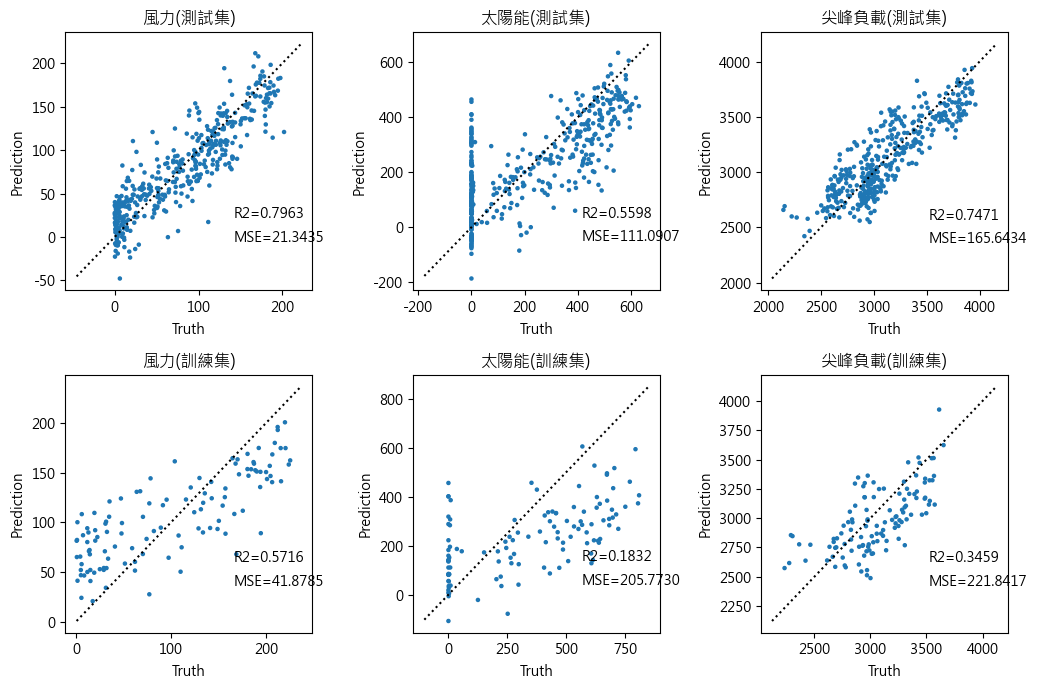

In [43]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches((10.5,7))
train_or_test = ['測試集', '訓練集']
for i in range(2):
    if i == 0:
        grand_X = np.array(Y_train)
        grand_Y = model.predict(X_train)
    elif i == 1:
        grand_X = np.array(Y_test)
        grand_Y = model.predict(X_test)
    for j in range(3):
        X = grand_X[:,j]
        Y = grand_Y[:,j]
        this_ax = axes[i][j]
        title = f'{Y_cols[j]}({train_or_test[i]})'
        plot_one_scatter(X, Y, this_ax, title)
fig.tight_layout()

# 特徵選取與特徵工程

In [44]:
def ModelFit(weather_power_df, X_cols, Y_cols, train_size=train_size, forced_non_negative=False, model = LinearRegression()):
    Xs = weather_power_df[X_cols]
    Ys = weather_power_df[Y_cols]
    
    X_train = np.array(Xs)[0:train_size,:]
    Y_train = np.array(Ys)[0:train_size,:]
    X_test = np.array(Xs)[train_size::,:]
    Y_test = np.array(Ys)[train_size::,:]
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    _ = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)
    print('訓練集')
    print('MSE of 風力, 太陽能, 尖峰負載 are:')
    print(mse_for_three(Y_train, Y_pred))
    
    Y_pred = model.predict(X_test)
    print('測試集')
    print('MSE of 風力, 太陽能, 尖峰負載 are:')
    print(mse_for_three(Y_test, Y_pred))
    
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches((10.5,7))
    train_or_test = ['測試集', '訓練集']
    for i in range(2):
        if i == 0:
            grand_X = np.array(Y_train)
            grand_Y = model.predict(X_train)
        elif i == 1:
            grand_X = np.array(Y_test)
            grand_Y = model.predict(X_test)
        for j in range(3):
            X = grand_X[:,j]
            Y = grand_Y[:,j]
            this_ax = axes[i][j]
            title = f'{Y_cols[j]}({train_or_test[i]})'
            plot_one_scatter(X, Y, this_ax, title)
    fig.tight_layout()
    return model

先刪除比較難以從預報得知的相對濕度，降水量與降水時數三者

In [45]:
X_cols = []
Y_cols = ['風力', '太陽能', '尖峰負載']
X_col_exclude = ['降水量', '降水時數']
for col in weather_power_df.columns:
    if not ((col in power_types.power_generation_big_type.keys() or col in Y_cols + ['日期']) or col.split('_')[0] in X_col_exclude):
        X_cols.append(col)
print(X_cols)

['氣溫_臺北', '最高氣溫_臺北', '最低氣溫_臺北', '相對溼度_臺北', '風速_臺北', '最大瞬間風_臺北', '日照時數_臺北', '日照率_臺北', '全天空日射量_臺北', '總雲量_臺北', '氣溫_高雄', '最高氣溫_高雄', '最低氣溫_高雄', '相對溼度_高雄', '風速_高雄', '最大瞬間風_高雄', '日照時數_高雄', '日照率_高雄', '全天空日射量_高雄', '總雲量_高雄', '氣溫_嘉義', '最高氣溫_嘉義', '最低氣溫_嘉義', '相對溼度_嘉義', '風速_嘉義', '最大瞬間風_嘉義', '日照時數_嘉義', '日照率_嘉義', '全天空日射量_嘉義', '總雲量_嘉義', '氣溫_東吉島', '最高氣溫_東吉島', '最低氣溫_東吉島', '相對溼度_東吉島', '風速_東吉島', '最大瞬間風_東吉島', '日照時數_東吉島', '日照率_東吉島', '全天空日射量_東吉島', '總雲量_東吉島', '氣溫_臺中電廠', '最高氣溫_臺中電廠', '最低氣溫_臺中電廠', '相對溼度_臺中電廠', '風速_臺中電廠', '最大瞬間風_臺中電廠', '東西風_臺北', '南北風_臺北', '東西陣風_臺北', '南北陣風_臺北', '東西風_高雄', '南北風_高雄', '東西陣風_高雄', '南北陣風_高雄', '東西風_嘉義', '南北風_嘉義', '東西陣風_嘉義', '南北陣風_嘉義', '東西風_東吉島', '南北風_東吉島', '東西陣風_東吉島', '南北陣風_東吉島', '東西風_臺中電廠', '南北風_臺中電廠', '東西陣風_臺中電廠', '南北陣風_臺中電廠', '日期數字']


訓練集
MSE of 風力, 太陽能, 尖峰負載 are:
[ 21.55684878 112.00871606 167.52305617]
測試集
MSE of 風力, 太陽能, 尖峰負載 are:
[ 41.48723086 208.27694501 224.58061226]


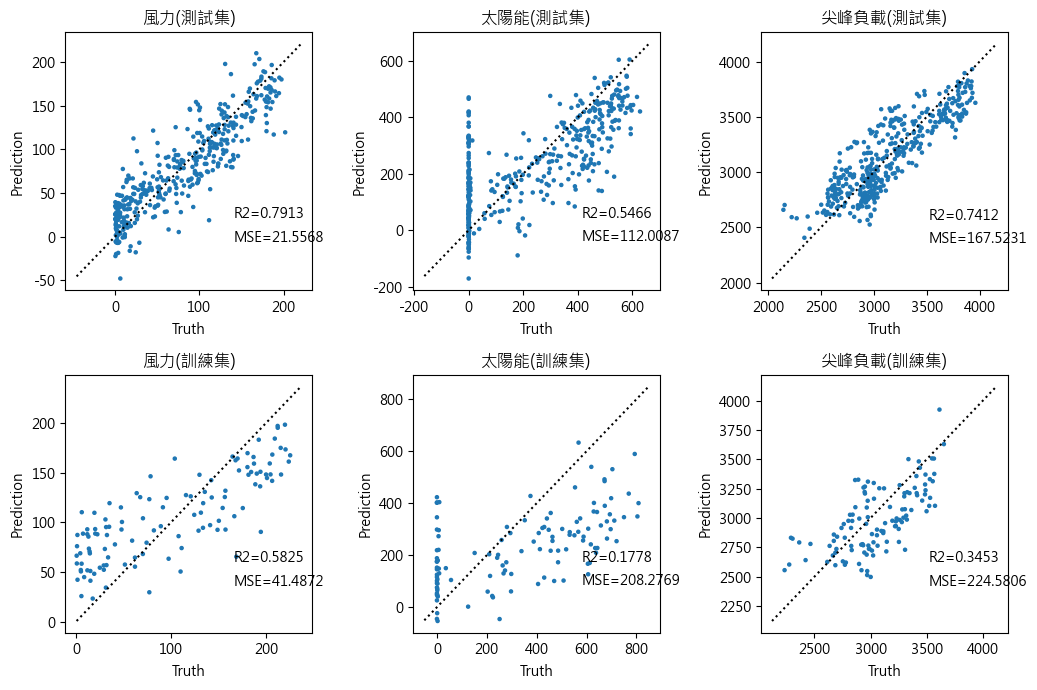

In [46]:
model = ModelFit(weather_power_df, X_cols, Y_cols)

將假日與工作日加進來

In [47]:
weather_power_df['假日'] = [1 if d in holidays else 0 for d in weather_power_df['日期']]
weather_power_df['週六'] = [1 if d.weekday() == 5 else 0 for d in weather_power_df['日期']]
weather_power_df['週日'] = [1 if d.weekday() == 6 else 0 for d in weather_power_df['日期']]
weather_power_df['補班'] = [1 if d.weekday() in adjusted_work_days else 0 for d in weather_power_df['日期']]


X_cols += ['假日', '週六', '週日', '補班']

訓練集
MSE of 風力, 太陽能, 尖峰負載 are:
[21.32164061 85.20089565 80.72416321]
測試集
MSE of 風力, 太陽能, 尖峰負載 are:
[ 40.59905926 146.49599683  85.83179492]


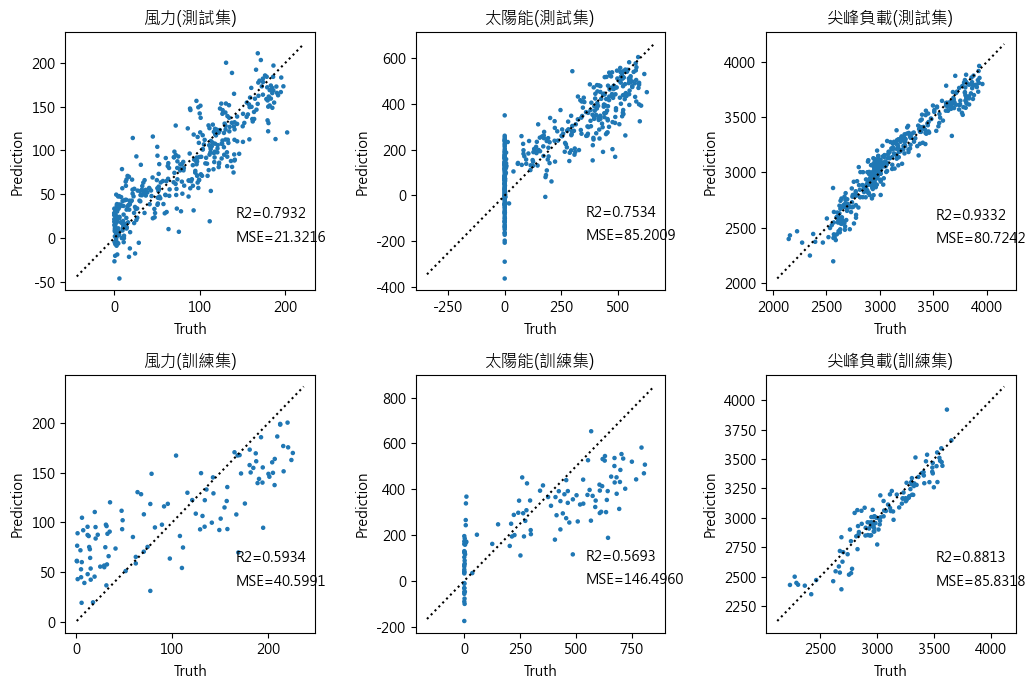

In [48]:
model = ModelFit(weather_power_df, X_cols, Y_cols)

將季節因素加進來

In [49]:
weather_power_df['1~3月'] = [1 if d.month in [1, 2, 3] and np.sum(weather_power_df[['假日', '週六', '週日']].iloc[i]) > 0 else 0\
                            for i, d in enumerate(weather_power_df['日期'])]
weather_power_df['11~12月'] = [1 if d.month in [11, 12] and np.sum(weather_power_df[['假日', '週六', '週日']].iloc[i]) > 0 else 0\
                              for d in weather_power_df['日期']]

X_cols += ['1~3月', '11~12月']

訓練集
MSE of 風力, 太陽能, 尖峰負載 are:
[21.29409085 77.3003941  76.51824963]
測試集
MSE of 風力, 太陽能, 尖峰負載 are:
[ 40.65406227 151.23793593  81.85057232]


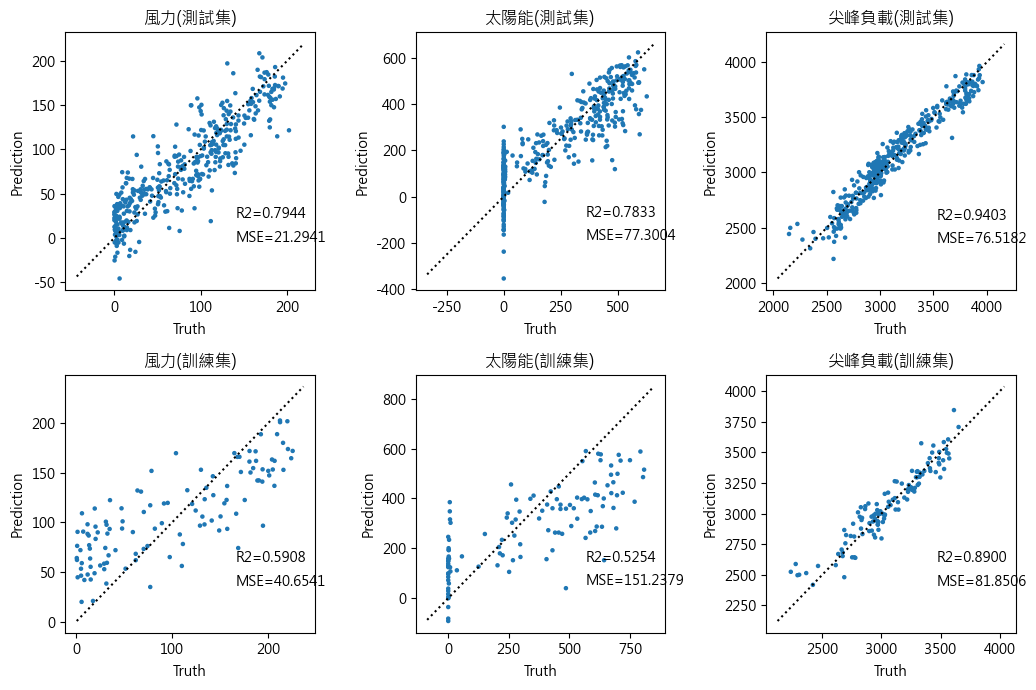

In [50]:
model = ModelFit(weather_power_df, X_cols, Y_cols)

歸納得知：
1. 刪除較難由氣象署預報預測的降水量與降水時數對模型準確度有微幅負面影響
2. 加入假日與工作日的變量，對太陽能與尖峰負載的準確度有重大正面影響
3. 加入季節因素的影響較不明顯